# Import libraries

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from keras.callbacks import ModelCheckpoint
from keras import regularizers

Using TensorFlow backend.


# Create a Fully Connected Network

In [2]:
# define the keras model

visible_1 = Input(shape=(978, 2))
flaten_1 = Flatten()(visible_1)
dense_11 = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(flaten_1)
drop_1 = Dropout(0.4)(dense_11)
dense_12 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(drop_1)
drop_2 = Dropout(0.4)(dense_12)
dense_13 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(drop_2)
drop_3 = Dropout(0.4)(dense_13)
dense_14 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(drop_3)
drop_4 = Dropout(0.4)(dense_14)
dense_15 = Dense(56, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(drop_4)
output_1 = Dense(1, activation='linear')(dense_15)
sequential = Model(inputs=visible_1, outputs=output_1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Feed Forward model summary

In [3]:
sequential.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 978, 2)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1956)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2003968   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1313

# Workflow
Our goal here is to combine the outputs of a FC model and VAE model - a process known as model ensemble (weighted sum)/model stacking (concatenation).
- Af of now, for 781 drugs:
    - For VAE model: features = (for each drug)(277 * 76)(Max_length * #production), labels = lab_experiment_shrinkage_measure(regression_value)
    - For FC model: features = (for each drug)(978 * 2)(#landmark_genes * #replicates), labels = lab_experiment_shrinkage_measure(regression_value)

# Create predictor setup

In [4]:
# Compile the model
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
sequential.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])  # Mean Squared Error and Mean Absolute Error as metrics for regression

# Load dummy datasets

In [5]:
# import h5py

# h5f = h5py.File('../../code/demo_data_train.h5', 'r')
# data_train = h5f['data'][:]
# h5f2 = h5py.File('../../code/demo_labels_train.h5', 'r')
# labels_train = h5f2['data'][:]
# h5f3 = h5py.File('../../code/demo_data_test.h5', 'r')
# data_test = h5f3['data'][:]
# h5f4 = h5py.File('../../code/demo_labels_test.h5', 'r')
# labels_test = h5f4['data'][:]

# print(data_train.shape)
# print(labels_train.shape)
# print(data_test.shape)
# print(labels_test.shape)

# Load gene expression datasets

In [6]:
import h5py

h5f = h5py.File('../../data/gene_exp_data_train_2.h5', 'r')
data_train = h5f['data'][:]
h5f2 = h5py.File('../../data/y_train_2.h5', 'r')
y_train = h5f2['data'][:]
h5f3 = h5py.File('../../data/gene_exp_data_test_2.h5', 'r')
data_test = h5f3['data'][:]
h5f4 = h5py.File('../../data/y_test_2.h5', 'r')
y_test = h5f4['data'][:]

print(data_train.shape)
print(y_train.shape)
print(data_test.shape)
print(y_test.shape)

(671, 978, 2)
(671,)
(100, 978, 2)
(100,)


In [7]:
y_test

array([ 6.16216492e-01, -3.39712934e-01,  2.17547224e-01,  3.95664836e-01,
        3.90705600e-01,  7.10555121e-01,  3.46706344e-01,  3.81025457e-01,
        2.67714004e-01,  2.70841345e-01,  3.31301712e-02,  9.07121771e-02,
        4.22754472e-01,  4.52810687e-01,  4.33372340e-01,  6.36648928e-02,
        3.98474591e-01, -8.00530133e-01,  1.78738951e-01, -7.96993281e-01,
        1.83022611e-01,  8.03028530e-02,  7.12376811e-01, -7.99776885e-01,
        1.27167481e-01,  2.32054570e-01, -2.54531133e-01,  6.01190313e-01,
        4.47950884e-01,  5.77949694e-01,  4.54120550e-01,  7.34896668e-01,
       -6.79074497e-01,  1.13255221e-01,  3.47945823e-01, -6.11277045e-01,
        1.13255221e-01,  5.95196190e-01,  2.37662674e-02, -7.99840053e-01,
       -7.75278133e-01,  2.25164550e-01,  7.54777698e-01,  1.01429794e-02,
        1.77482229e-01,  2.07344648e-01,  2.72686118e-01,  2.89649806e-01,
        4.23633394e-01, -5.65508359e-01, -3.40987956e-01, -1.05350202e-01,
       -1.33956367e-01,  

# Load pretrained weights

In [8]:
# Remove Nan values from data and labels
import numpy as np
# data_train = np.nan_to_num(data_train)
data_test = np.nan_to_num(data_test)
y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)

# Remove Inf values from data and labels
# data_train[data_train == np.inf] = 0
data_test[data_test == np.inf] = 0
y_train[y_train == np.inf] = 0
y_test[y_test == np.inf] = 0

In [9]:
# sequential.load_weights('../../data/sequential.h5')

In [10]:
# Set up ModelCheckpoint to save weights for the epoch with the best validation loss
# checkpoint_filepath = "../../data/best_weights.h5"
# checkpoint_filepath = "../../data/sample_weights.h5"
# checkpoint_filepath = "../../data/sample_weights_lr_sched.h5"
checkpoint_filepath = "../../data/sample_weights_lr_sched_2.h5"
model_checkpoint = ModelCheckpoint(checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model

In [11]:
# Train the model and obtain the training history
history = sequential.fit(data_train, y_train, 
                         validation_data=(data_test, y_test), 
                         epochs=200, batch_size=50, verbose=2,
                         callbacks=[model_checkpoint]
                         )


Train on 671 samples, validate on 100 samples
Epoch 1/200
 - 1s - loss: nan - mae: nan - val_loss: nan - val_mae: nan

Epoch 00001: val_loss did not improve from inf
Epoch 2/200
 - 1s - loss: nan - mae: nan - val_loss: nan - val_mae: nan

Epoch 00002: val_loss did not improve from inf
Epoch 3/200
 - 1s - loss: nan - mae: nan - val_loss: nan - val_mae: nan

Epoch 00003: val_loss did not improve from inf
Epoch 4/200
 - 1s - loss: nan - mae: nan - val_loss: nan - val_mae: nan

Epoch 00004: val_loss did not improve from inf
Epoch 5/200
 - 1s - loss: nan - mae: nan - val_loss: nan - val_mae: nan

Epoch 00005: val_loss did not improve from inf
Epoch 6/200
 - 1s - loss: nan - mae: nan - val_loss: nan - val_mae: nan

Epoch 00006: val_loss did not improve from inf
Epoch 7/200
 - 1s - loss: nan - mae: nan - val_loss: nan - val_mae: nan

Epoch 00007: val_loss did not improve from inf
Epoch 8/200
 - 1s - loss: nan - mae: nan - val_loss: nan - val_mae: nan

Epoch 00008: val_loss did not improve fr

KeyboardInterrupt: 

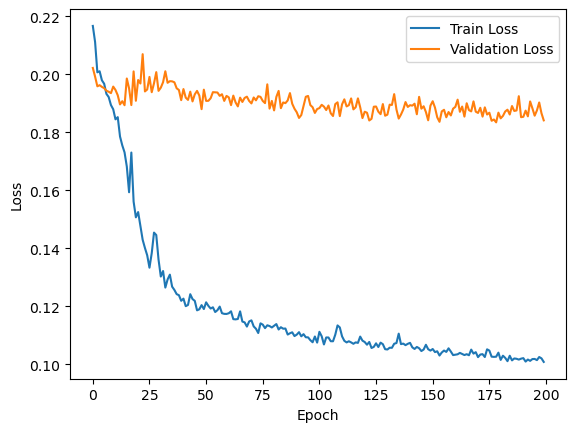

In [ ]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

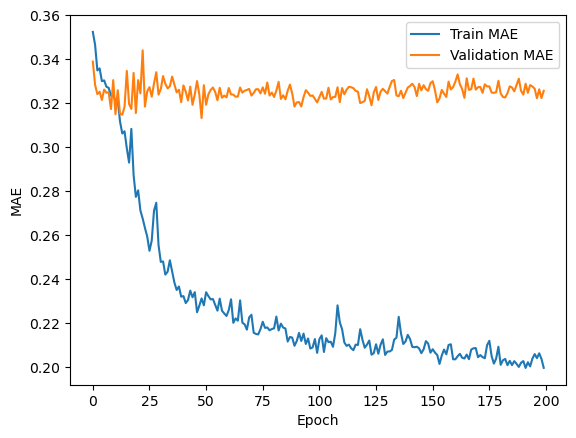

In [ ]:
# Plot the training and validation MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
# Load the best weights based on the optimal epoch
sequential.load_weights(checkpoint_filepath)

In [ ]:
# Find the epoch with the minimum validation loss
optimal_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
print(f"Optimal Epoch: {optimal_epoch} loss: {history.history['val_loss'][optimal_epoch-1]}")

Optimal Epoch: 179 loss: 0.1833948865532875


In [ ]:
# Save the best weights based on optimal epoch
# sequential.save_weights('sequential.h5')

In [ ]:
# # Train the model
# epochs = 325
# batch_size = 50
# sequential.fit(data_train, y_train, epochs=epochs, batch_size=batch_size)

# Evaluate the model

In [ ]:
# Evaluate the model on the test set
results = sequential.evaluate(data_test, y_test)

100/100 [==============================] - 0s 384us/step


# Results

In [ ]:
# Print the evaluation results
print("Test Loss:", results[0])
print("Test MAE:", results[1])

Test Loss: 0.1833948814868927
Test MAE: 0.3250601887702942


[[1.        0.0758718]
 [0.0758718 1.       ]]
-0.02331451018099817


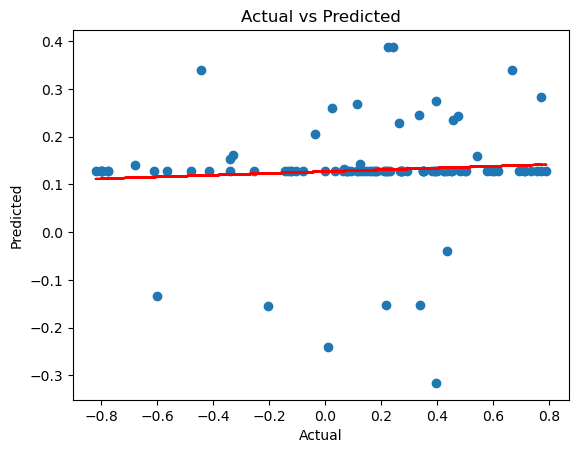

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
y_pred = sequential.predict(data_test)
print(np.corrcoef(y_test, y_pred.ravel()))
print(r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, 'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Save model weights

In [ ]:
# sequential.save_weights('../../data/sequential.h5')
# print("Model weights saved to '../../data/sequential.h5'")

# Finish!

# Test the model

In [ ]:
# Load test set for gene expression data
h5f = h5py.File('../../data/gene_exp_test_data.h5', 'r')
seq_test_data = h5f['data'][:]
# h5f = h5py.File('../../data/vae_test_data.h5', 'r')
# vae_test_data = h5f['data'][:]

print(seq_test_data.shape)
# print(vae_test_data.shape)

(910, 978, 2)


In [ ]:
from densenet import DenseNet

model = DenseNet()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 978, 2)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1956)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2003968   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               1313

## Learning rate scheduler

In [ ]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import LearningRateScheduler

# def lr_schedule(epoch):
#     """Learning rate scheduler."""
#     initial_lr = 0.001
#     drop = 0.5
#     epochs_drop = 10
#     lr = initial_lr * (drop ** (epoch // epochs_drop))
#     return lr

# adam_optimizer = Adam(lr=0.001)  # Initial learning rate
# model.compile(optimizer=adam_optimizer, loss='mean_squared_error', metrics=['accuracy'])

# # Use LearningRateScheduler callback
# lr_scheduler = LearningRateScheduler(lr_schedule)
# history = model.fit(x_train, y_train, epochs=50, callbacks=[lr_scheduler], ...)
